# Подготовка данных

In [ ]:
#! pip install numpy librosa tqdm matplotlib

In [11]:
import os
import shutil
import sys
import tarfile
import urllib.request
from pathlib import Path
import numpy as np
import librosa
from tqdm import tqdm
import json
from matplotlib import pyplot as plt

In [12]:
PROJECT_ROOT = Path(".").parent
DATA_DIR = PROJECT_ROOT / "data" / "aishell3"
PROCESSED_DIR = PROJECT_ROOT / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

In [13]:
AISHELL3_URL = "http://www.openslr.org/resources/93/data_aishell3.tgz"

In [14]:
def download_aishell3():
    """Скачивает AISHELL-3, если ещё не скачан"""
    tar_path = DATA_DIR / "data_aishell3.tgz"
    if tar_path.exists():
        print("AISHELL-3 архив уже скачан")
        return tar_path

    print("Скачивание AISHELL-3")
    def reporthook(block_num, block_size, total_size):
        if total_size > 0:
            percent = min(100, (block_num * block_size * 100) // total_size)
            print(f"\rПрогресс: {percent}%", end="")
    urllib.request.urlretrieve(AISHELL3_URL, tar_path, reporthook)
    print("\nЗагрузка завершена")
    
    return tar_path

In [15]:
def extract_aishell3(tar_path: Path):
    """Распаковывает AISHELL-3"""
    if (DATA_DIR / "train").exists() and (DATA_DIR / "test").exists():
        print("AISHELL-3 уже распакован")
        return

    print("Распаковка")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(DATA_DIR.parent)

    src_dir = DATA_DIR.parent / "data_aishell3"
    if src_dir.exists():
        for item in src_dir.iterdir():
            shutil.move(str(item), str(DATA_DIR))
        shutil.rmtree(src_dir)
    print("Распаковка завершена")

In [16]:
def load_content_labels():
    content_path = DATA_DIR / "train" / "content.txt"
    labels = {}
    with open(content_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            
            if not parts:
                continue
            
            wav_id = parts[0].replace(".wav", "")
            for i, p in enumerate(parts[1:], 1):
                if p[-1].isdigit() and p[:-1].isalpha():
                    syllables = parts[i:]
                    labels[wav_id] = syllables
                    break
                
    return labels

In [21]:
def process_wav_file(wav_id, syllables):
    """Оптимизированная обработка одного WAV-файла:
        - Загрузка 1 раз
        - Нормализация по диктору (глобальная для файла)
        - Быстрый фильтр по амплитуде
    """
    speaker = wav_id[:7]
    wav_path = DATA_DIR / "train" / "wav" / speaker / f"{wav_id}.wav"
    if not wav_path.exists():
        return []

    # Загружаем ОДИН раз
    y, sr = librosa.load(wav_path, sr=16000)
    if len(y) == 0:
        return []

    # Сохраняем исходную амплитуду для фильтрации
    max_amp = np.max(np.abs(y))
    if max_amp == 0:
        return []
    
    # Нормализуем для стабильности
    y_norm = y / max_amp

    duration = len(y) / sr
    n_syl = len(syllables)
    results = []

    for i, syl in enumerate(syllables):
        start = i * duration / n_syl
        end = (i + 1) * duration / n_syl
        start_idx = int(start * sr)
        end_idx = int(end * sr)
        y_seg = y_norm[start_idx:end_idx]

        if len(y_seg) == 0:
            continue

        # пропускаем тихие сегменты
        seg_max = np.max(np.abs(y_seg))
        if seg_max < 0.05:  # 5% от максимума диктора
            continue

        # уменьшенные параметры для скорости
        f0, _, _ = librosa.pyin(
            y_seg,
            fmin=librosa.note_to_hz('C2'),   # ~65 Гц
            fmax=librosa.note_to_hz('C7'),   # ~2093 Гц
            sr=sr,
            frame_length=512,
            hop_length=128
        )
        f0 = f0[~np.isnan(f0)]
        if len(f0) < 5:
            continue

        tone = int(syl[-1]) if syl[-1].isdigit() else 5
        results.append((f0.astype(np.float32), tone))

    return results

In [22]:
for fname in ["f0_raw.npy", "tones.npy"]:
    fpath = PROCESSED_DIR / fname
    if fpath.exists():
        fpath.unlink()
        print(f"Удалён старый файл: {fpath}")

Удалён старый файл: processed\f0_raw.npy
Удалён старый файл: processed\tones.npy


In [23]:
# Загрузка и обработка
labels = load_content_labels()
all_f0, all_tones = [], []

print("Обработка файлов")
for wav_id, syllables in tqdm(list(labels.items())[:1000]):
    results = process_wav_file(wav_id, syllables)
    all_f0.extend(f for f, _ in results)
    all_tones.extend(t for _, t in results)

# Сохранение
np.save(PROCESSED_DIR / "f0_raw.npy", np.array(all_f0, dtype=object), allow_pickle=True)
np.save(PROCESSED_DIR / "tones.npy", np.array(all_tones))
print(f"Обработано {len(all_f0)} слогов")

Обработка файлов


100%|██████████| 1000/1000 [1:21:03<00:00,  4.86s/it]

Обработано 15743 слогов


# Диагностика данных

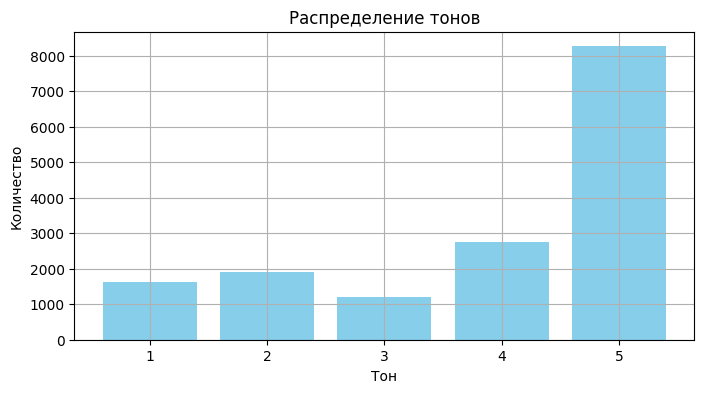

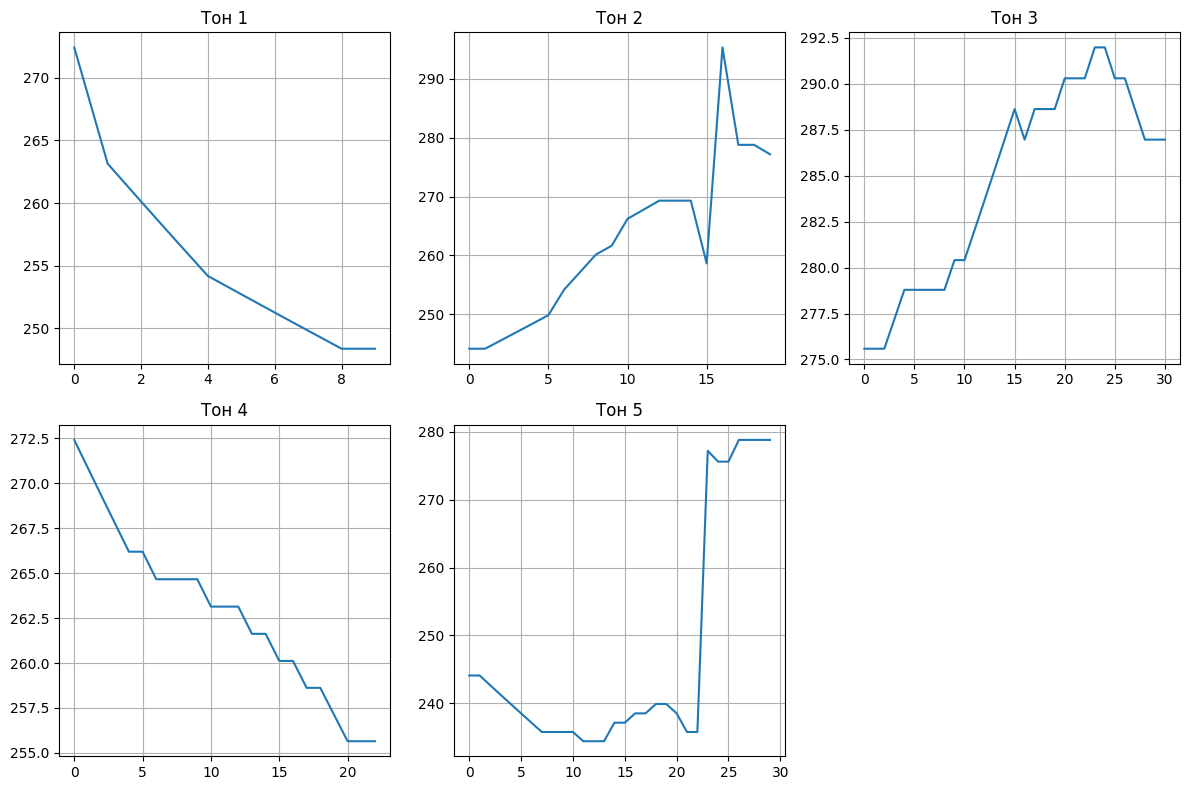

In [24]:
# Загрузка
f0_raw = np.load(PROCESSED_DIR / "f0_raw.npy", allow_pickle=True)
tones = np.load(PROCESSED_DIR / "tones.npy")

# Распределение тонов
plt.figure(figsize=(8, 4))
plt.hist(tones, bins=np.arange(0.5, 6.5, 1), rwidth=0.8, color='skyblue')
plt.xticks([1,2,3,4,5])
plt.title("Распределение тонов")
plt.xlabel("Тон")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

# Примеры F0-контуров
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flat
for tone in range(1, 6):
    idxs = np.where(tones == tone)[0]
    if len(idxs) == 0:
        continue
    ax = axes[tone - 1]
    ax.plot(f0_raw[idxs[0]], color='C0')
    ax.set_title(f"Тон {tone}")
    ax.grid(True)
axes[5].set_visible(False)
plt.tight_layout()
plt.show()

# Обучение CNN